In [1]:
from keras.datasets import cifar10
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage import color
from skimage import io
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras
from keras import layers
from keras.models import Sequential
from sklearn.metrics import precision_score , recall_score, f1_score, accuracy_score
import seaborn as sb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from numpy import array, dot, mean, std, empty, argsort
from numpy.linalg import eigh, solve

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 13s 0us/step


In [3]:
x_train = color.rgb2gray(x_train)
x_test = color.rgb2gray(x_test)
x_train_ = x_train.reshape((len(x_train),1024))  
x_test_ = x_test.reshape((len(x_test),1024))   

In [4]:
def cov(X):
  return dot(X.T, X) / X.shape[0]

In [5]:
pca = PCA()
pca.fit(x_train_)
cumsum = np.cumsum(pca.explained_variance_ratio_)

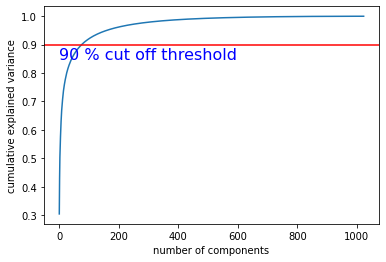

In [6]:
plt.plot(cumsum)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(y = 0.9, color = 'r', linestyle = '-')
plt.text(0.5, 0.85, '90 % cut off threshold', color = 'b', fontsize = 16)
plt.show()

In [7]:
def pca(data, pc_count = None):

    data -= mean(data, 0)
    data /= std(data, 0)
    C = cov(data)
    E, V = eigh(C)
    key = argsort(E)[::-1][:pc_count]
    E, V = E[key], V[:, key]
    U = dot(data, V)  
    return U

In [10]:
new_train_ = pca(x_train_, 400)
new_test_ = pca(x_test_, 400)

(50000, 400)

In [11]:
new_train_ = new_train_.reshape(new_train_.shape[0],20,20,1)
new_test_ = new_test_.reshape(new_test_.shape[0],20,20,1)

(50000, 20, 20, 1)

In [12]:
(new_train_, x_valid_) = new_train_[5000:], new_train_[:5000]
(y_train, y_valid_) = y_train[5000:], y_train[:5000]

In [13]:
model = Sequential()

model.add(layers.Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (20, 20, 1))) 
model.add(layers.MaxPooling2D(pool_size = 2))

model.add(layers.Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = 2))


model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'sigmoid'))
model.add(layers.Dense(10, activation = 'softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 512)               8

In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
trainedModel = model.fit(new_train_, y_train, batch_size = 128, epochs = 30, validation_data = (x_valid_,y_valid_))

Epoch 1/30
352/352 [==============================] - 12s 6ms/step - loss: 1.9462 - accuracy: 0.3018 - val_loss: 1.7742 - val_accuracy: 0.3712
Epoch 2/30
352/352 [==============================] - 2s 5ms/step - loss: 1.7634 - accuracy: 0.3731 - val_loss: 1.7057 - val_accuracy: 0.3972
Epoch 3/30
352/352 [==============================] - 2s 5ms/step - loss: 1.6842 - accuracy: 0.4056 - val_loss: 1.6694 - val_accuracy: 0.4046
Epoch 4/30
352/352 [==============================] - 2s 5ms/step - loss: 1.6186 - accuracy: 0.4289 - val_loss: 1.6509 - val_accuracy: 0.4202
Epoch 5/30
352/352 [==============================] - 2s 5ms/step - loss: 1.5618 - accuracy: 0.4494 - val_loss: 1.6192 - val_accuracy: 0.4288
Epoch 6/30
352/352 [==============================] - 2s 5ms/step - loss: 1.5038 - accuracy: 0.4707 - val_loss: 1.6288 - val_accuracy: 0.4288
Epoch 7/30
352/352 [==============================] - 2s 5ms/step - loss: 1.4416 - accuracy: 0.4932 - val_loss: 1.6224 - val_accuracy: 0.4332
Epoch

In [15]:
y_pred_ = np.argmax(model.predict(new_test_), axis=-1)

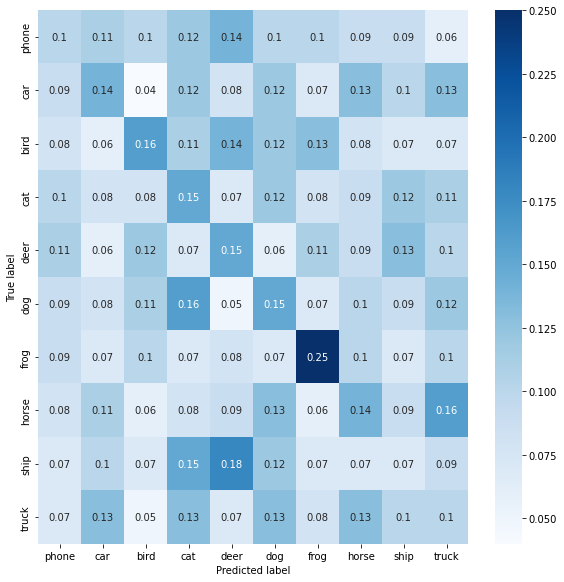

In [16]:
ImgLabel = ["phone", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
conf_m = tf.math.confusion_matrix(labels = y_test, predictions = y_pred_).numpy()
conf_m_norm = np.around(conf_m.astype('float') / conf_m.sum(axis=1)[:, np.newaxis], decimals=2)
conf_m_df = pd.DataFrame(conf_m_norm, index = ImgLabel, columns = ImgLabel)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(conf_m_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

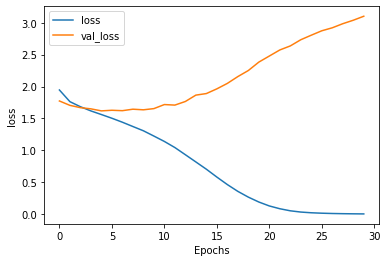

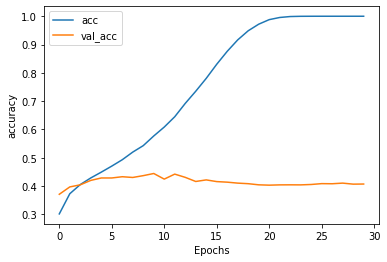

In [17]:
history = trainedModel.history
loss = history['loss']
val_loss = history['val_loss']
acc = history['accuracy']
val_acc = history['val_accuracy']
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss','val_loss'])
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.plot(acc)
plt.plot(val_acc)
plt.legend(['acc','val_acc'])

In [18]:
test_loss,test_accuracy = model.evaluate(new_test_,y_test)
print('test loss = %f' % test_loss)
print('test accuracy = %f' % test_accuracy)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred_)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred_, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_, average='macro')
print('F1 score: %f' % f1)

313/313 [==============================] - 1s 3ms/step - loss: 6.3528 - accuracy: 0.1404
test loss = 6.352817
test accuracy = 0.140400
Accuracy: 0.140400
Precision: 0.140156
Recall: 0.140400
F1 score: 0.140011


In [ ]:
x_train = (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train))

x_test = (x_test - np.min(x_test)) / (np.max(x_test) - np.min(x_test))


x_train = x_train.reshape((len(x_train),1024))  
x_test = x_test.reshape((len(x_test),1024))    

In [ ]:
encoding_dim = 256
input_img = keras.Input(shape=(1024,))
encoded = layers.Dense(800, activation='relu')(input_img)
encoded = layers.Dense(512, activation='relu')(input_img)
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)

decoded = layers.Dense(512, activation='relu')(encoded)
decoded = layers.Dense(800, activation='relu')(encoded)
decoded = layers.Dense(1024, activation='sigmoid')(encoded)

In [ ]:
autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)

autoencoder.compile(optimizer = 'adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs = 40, batch_size = 256, validation_data = (x_test, x_test))



Epoch 1/40
196/196 [==============================] - 4s 7ms/step - loss: 0.6362 - val_loss: 0.6130
Epoch 2/40
196/196 [==============================] - 1s 6ms/step - loss: 0.6040 - val_loss: 0.5974
Epoch 3/40
196/196 [==============================] - 1s 6ms/step - loss: 0.5939 - val_loss: 0.5912
Epoch 4/40
196/196 [==============================] - 1s 6ms/step - loss: 0.5895 - val_loss: 0.5889
Epoch 5/40
196/196 [==============================] - 1s 6ms/step - loss: 0.5874 - val_loss: 0.5873
Epoch 6/40
196/196 [==============================] - 1s 6ms/step - loss: 0.5861 - val_loss: 0.5855
Epoch 7/40
196/196 [==============================] - 1s 6ms/step - loss: 0.5844 - val_loss: 0.5847
Epoch 8/40
196/196 [==============================] - 1s 6ms/step - loss: 0.5837 - val_loss: 0.5882
Epoch 9/40
196/196 [==============================] - 1s 6ms/step - loss: 0.5828 - val_loss: 0.5835
Epoch 10/40
196/196 [==============================] - 1s 6ms/step - loss: 0.5823 - val_loss: 0.5829

In [ ]:
test1 = encoder.predict(x_test)
train1 = encoder.predict(x_train)

new_test = test1.reshape(test1.shape[0], 16, 16, 1)
new_train = train1.reshape(train1.shape[0], 16, 16, 1)

In [ ]:
(new_train, x_valid) = new_train[5000:], new_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

In [ ]:

model = Sequential()

model.add(layers.Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (16, 16, 1))) 
model.add(layers.MaxPooling2D(pool_size = 2))

model.add(layers.Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = 2))


model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'sigmoid'))
model.add(layers.Dense(10, activation = 'softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               5

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
trainedModel = model.fit(new_train, y_train, batch_size = 32, epochs = 30, validation_data = (x_valid,y_valid))

Epoch 1/30
1407/1407 [==============================] - 16s 6ms/step - loss: 2.0221 - accuracy: 0.2695 - val_loss: 1.9107 - val_accuracy: 0.3162
Epoch 2/30
1407/1407 [==============================] - 8s 6ms/step - loss: 1.8670 - accuracy: 0.3352 - val_loss: 1.8197 - val_accuracy: 0.3484
Epoch 3/30
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7899 - accuracy: 0.3639 - val_loss: 1.7952 - val_accuracy: 0.3452
Epoch 4/30
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7245 - accuracy: 0.3873 - val_loss: 1.7207 - val_accuracy: 0.3938
Epoch 5/30
1407/1407 [==============================] - 8s 6ms/step - loss: 1.6681 - accuracy: 0.4121 - val_loss: 1.7148 - val_accuracy: 0.3928
Epoch 6/30
1407/1407 [==============================] - 8s 6ms/step - loss: 1.6138 - accuracy: 0.4327 - val_loss: 1.6713 - val_accuracy: 0.4166
Epoch 7/30
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5559 - accuracy: 0.4495 - val_loss: 1.6364 - val_accuracy

In [ ]:
y_pred = np.argmax(model.predict(new_test), axis=-1)

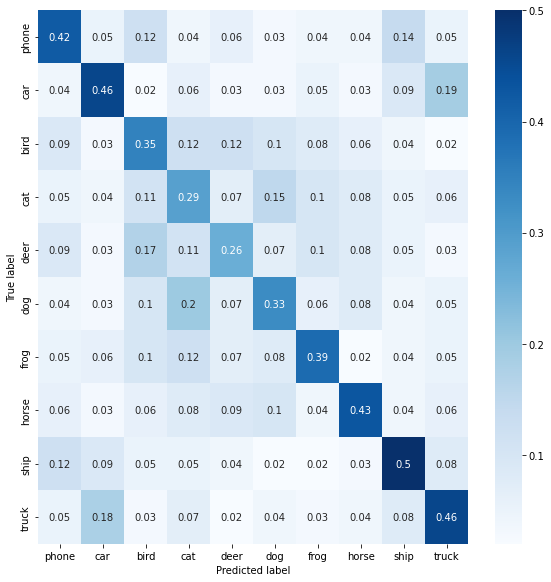

In [ ]:
ImgLabel = ["phone", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
conf_m = tf.math.confusion_matrix(labels = y_test, predictions = y_pred).numpy()
conf_m_norm = np.around(conf_m.astype('float') / conf_m.sum(axis=1)[:, np.newaxis], decimals=2)
conf_m_df = pd.DataFrame(conf_m_norm, index = ImgLabel, columns = ImgLabel)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(conf_m_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

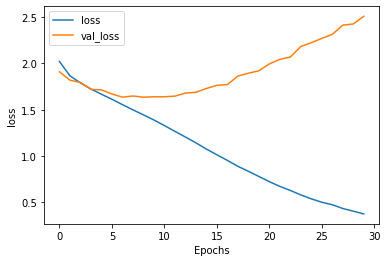

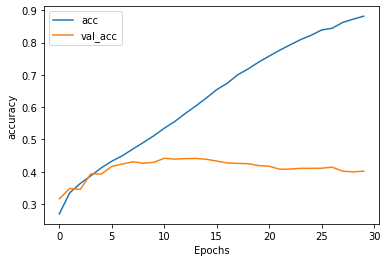

In [ ]:
history = trainedModel.history
loss = history['loss']
val_loss = history['val_loss']
acc = history['accuracy']
val_acc = history['val_accuracy']
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss','val_loss'])
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.plot(acc)
plt.plot(val_acc)
plt.legend(['acc','val_acc'])

In [ ]:
test_loss,test_accuracy = model.evaluate(new_test,y_test)
print('test loss = %f' % test_loss)
print('test accuracy = %f' % test_accuracy)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='macro')
print('F1 score: %f' % f1)



313/313 [==============================] - 1s 4ms/step - loss: 2.6067 - accuracy: 0.3884
test loss = 2.606713
test accuracy = 0.388400
Accuracy: 0.388400
Precision: 0.390786
Recall: 0.388400
F1 score: 0.388675


In [ ]:
data = pd.read_csv ('data.csv')

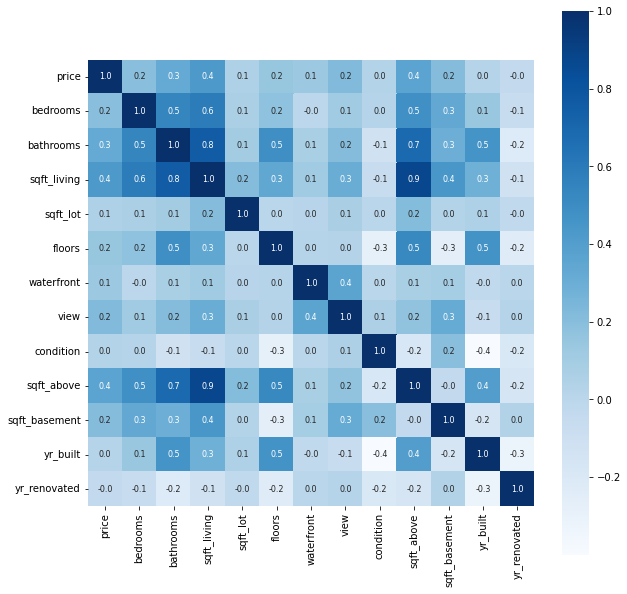

In [ ]:
c = data.corr()
plt.figure(figsize = (10, 10))
sb.heatmap(c, cbar = True, square = True, fmt = '.1f', annot = True, annot_kws = {'size':8}, cmap = 'Blues')

In [ ]:
numeric_data = cat_data = data.select_dtypes(exclude = ['object'])
x = data[["bedrooms", "sqft_living", "yr_built", "sqft_above"]]
y = data["price"]
regressor = LinearRegression()
regressor.fit(x, y)
features = pd.DataFrame(regressor.coef_, x.columns, columns=['coefficient'])
features.coefficient = features.coefficient.abs()
print(features)

              coefficient
bedrooms     55912.752126
sqft_living    291.073867
yr_built      2239.164929
sqft_above      15.488798


In [ ]:
stdevs = []
for i in x.columns:
    stdev = data[i].std()
    stdevs.append(stdev)
 
import numpy as np
features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]
features['importance_normalized'] = 100*features['importance'] / features['importance'].max()

<BarContainer object of 4 artists>

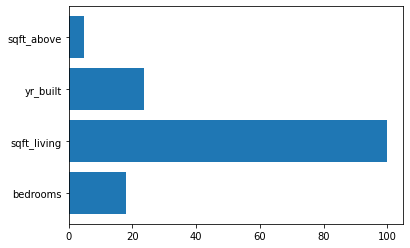

In [ ]:
plt.barh(features.index, features.importance_normalized)

<BarContainer object of 4 artists>

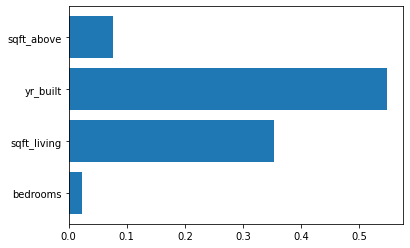

In [ ]:
tree =DecisionTreeRegressor().fit(x, y)
feature_importance = tree.feature_importances_
plt.barh(features.index, feature_importance)